## Imports

In [1]:
import pickle
import json

import pandas as pd
from tqdm import tqdm
import xarray as xr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path

from applefy.detections.uncertainty import compute_detection_uncertainty
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, fpf_2_gaussian_sigma

In [2]:
test = TTest()

In [3]:
photometry_mode_planet = AperturePhotometryMode(
    "FS",
    psf_fwhm_radius=2.1,
    search_area=0.5)

photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=2.1)

In [4]:
lambda_regs = np.logspace(1, 8, 50)
mask_sizes = [4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
fake_planets = ["0000", 
                "0071a", "0117a", 
                "0142b", "0188b", 
                "0190c", "0236c",
                "0240d", "0286d",
                "0267e", "0336e",
                "0317f", "0363f",
                "0343a", "0389a"]

## Files of general interest

In [5]:
models_root_dir = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm/")

In [6]:
fake_planet_config_dirs = Path("/fast/mbonse/s4/30_data/0100_C-0656-A/configs_cgrid/")

## Unwrap the planet positions of the fake planets

In [ ]:
position_lookup_table = dict()
separation_lookup_table = dict()

for tmp_config in fake_planet_config_dirs.iterdir():

    with open(tmp_config) as json_file:
        fake_planet_config = json.load(json_file)
        
    if fake_planet_config["exp_id"] == "0000":
        continue
    
    position_lookup_table[fake_planet_config["exp_id"]] = fake_planet_config["planet_position"][:2]
    separation_lookup_table[fake_planet_config["exp_id"]] = fake_planet_config["separation"]

In [ ]:
separation_lookup_table

In [ ]:
position_lookup_table

## Calculate the SNR - Load the residual cubes

In [ ]:
residual_cube = xr.open_dataset(models_root_dir/ Path("median_residual_combined.nc"))

## Calculate the SNR of all datasets

In [ ]:
from joblib import Parallel, delayed

In [ ]:
def calculate_snr(setup):
    
    residual_image, planet_position, tmp_mask, tmp_lambda, tmp_planet = setup
    
    result = compute_detection_uncertainty(
        frame=residual_image, 
        planet_position=planet_position,
        statistical_test=test,
        psf_fwhm_radius=2.1,
        photometry_mode_noise=photometry_mode_noise,
        photometry_mode_planet=photometry_mode_planet,
        safety_margin=1,
        num_rot_iter=20)
    
    return tmp_planet, tmp_mask, tmp_lambda, fpf_2_gaussian_sigma(result[0])

In [ ]:
setups = []

for tmp_planet in position_lookup_table.keys():
    for tmp_mask in residual_cube.coords["mask"]:
        for tmp_lambda in lambda_regs:
            tmp_image = residual_cube.sel(
                fake_planet_id=tmp_planet, 
                mask=tmp_mask,
                lamb=tmp_lambda).to_array().to_numpy()[0]

            tmp_position = position_lookup_table[tmp_planet]

            setups.append((tmp_image, tmp_position, float(tmp_mask), tmp_lambda, tmp_planet))

In [47]:
%%time 
results = Parallel(n_jobs=8)(delayed(calculate_snr)(tmp_setup) for tmp_setup in setups)

CPU times: user 5.33 s, sys: 1.54 s, total: 6.87 s
Wall time: 12min 43s


In [12]:
with open("result_data/snr_values.pickle", "rb") as input_file:
   snr_results = pickle.load(input_file)

In [13]:
snr_results = pd.DataFrame(
    snr_results, 
    columns=['planet', 'mask_size', 'lambda_reg', 'snr'])

In [14]:
snr_results.set_index(['planet', 'mask_size', 'lambda_reg'], inplace=True)

In [15]:
snr_results = snr_results.to_xarray()

## Plot the heatmaps of the SNR

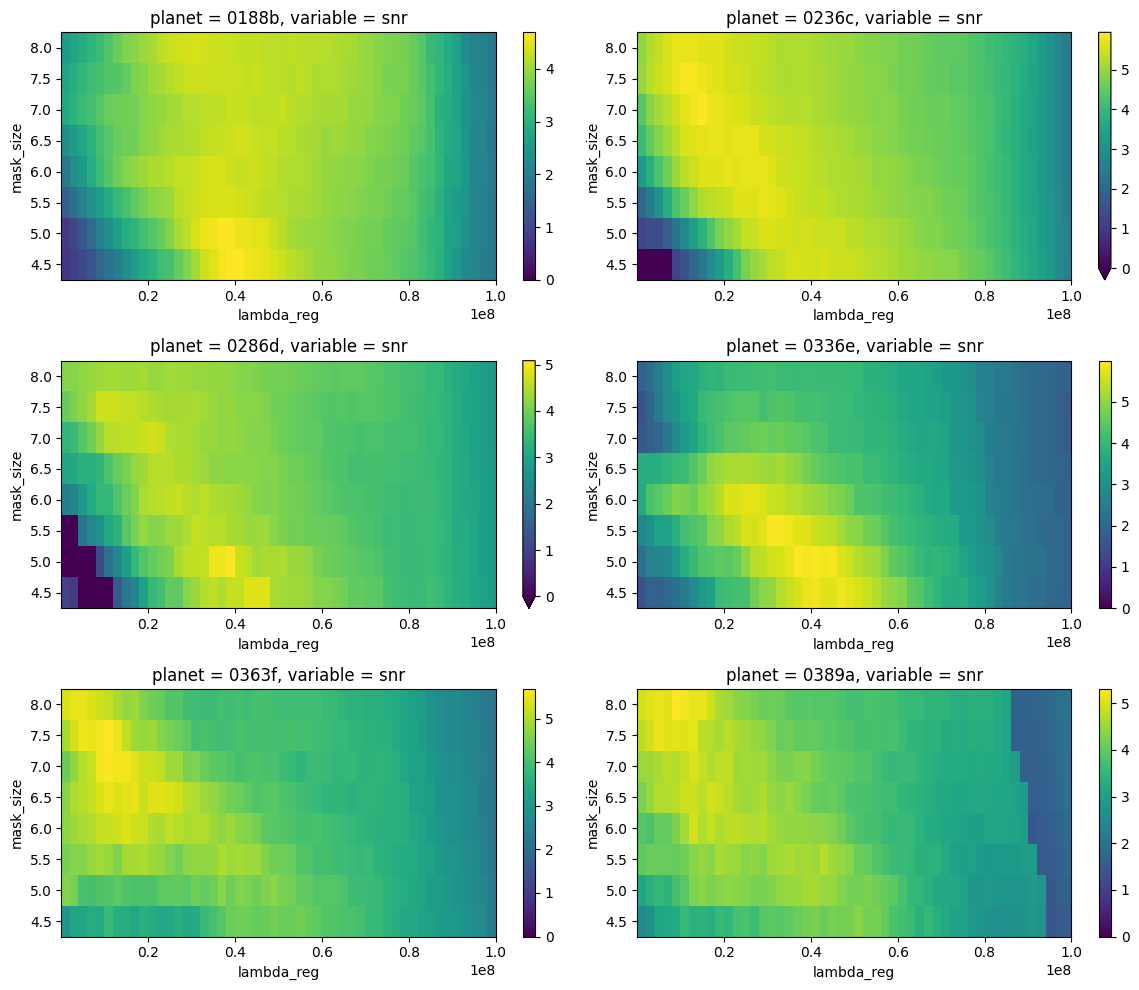

In [16]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 10))


xr.plot.imshow(snr_results.sel(planet="0188b").to_array()[0],
               vmin=0, ax=ax1)

xr.plot.imshow(snr_results.sel(planet="0236c").to_array()[0], 
               vmin=0, ax=ax2)

xr.plot.imshow(snr_results.sel(planet="0286d").to_array()[0], 
               vmin=0, ax=ax3)

xr.plot.imshow(snr_results.sel(planet="0336e").to_array()[0], 
               vmin=0, ax=ax4)

xr.plot.imshow(snr_results.sel(planet="0363f").to_array()[0], 
               vmin=0, ax=ax5)

xr.plot.imshow(snr_results.sel(planet="0389a").to_array()[0], 
               vmin=0, ax=ax6)

plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_snr_heatmaps.pdf")

## Plot trends of the mask size for different lambda

In [17]:
colors = sns.color_palette("magma", 6)

# We skip a planets at 1 lambda /D. They are special...
skip = ["0071a", "0117a", "0142b", "0190c", "0240d", "0267e", "0317f","0343a"]

def plot_mask_trend(
    lambda_in,
    name_in, 
    ax_in):
    
    if lambda_in == "BEST":
        mask_size_results = snr_results.max(
            dim="lambda_reg").to_array()[0]
    else:
        mask_size_results = snr_results.sel(
            lambda_reg=lambda_in).to_array()[0]

    idx = 0
    for tmp_planet_result in mask_size_results:

        tmp_planet_name = str(tmp_planet_result.planet.values)

        if tmp_planet_name in skip:
            continue

        ax_in.plot(
            snr_results.coords["mask_size"], 
            tmp_planet_result, 
            label=tmp_planet_name,
            color=colors[idx])
        idx +=1
        
    ax_in.set_xlabel("Mask size")
    ax_in.set_ylabel("Detection confidence [$\sigma_{\mathcal{N}}$]")
    ax_in.set_title("Lambda = " + name_in)
    ax_in.set_ylim(3, 6.2)
    ax_in.grid()

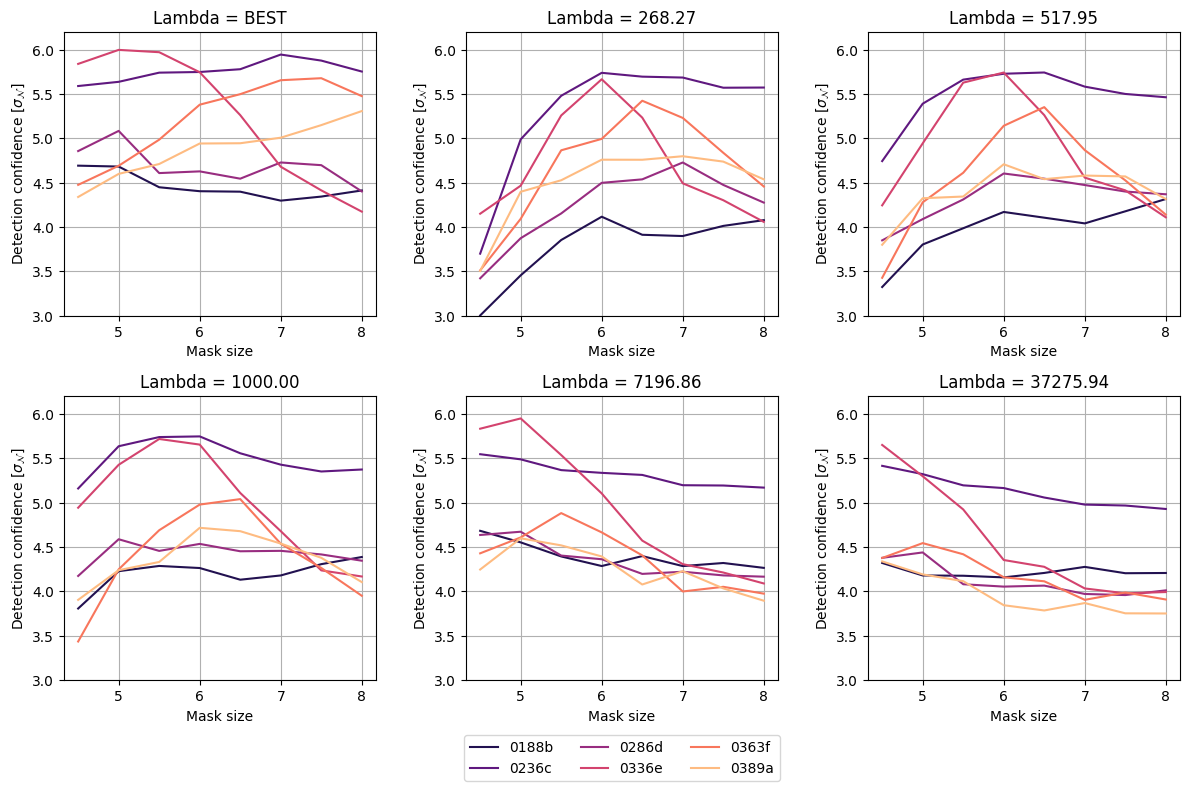

In [18]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))


for i in [(ax1, "best"), (ax2, 10), (ax3, 12), (ax4, 14), (ax5, 20), (ax6, 25)]:
    tmp_ax, tmp_idx = i
    if tmp_idx!= "best":
        tmp_lambda = float(snr_results.coords["lambda_reg"][tmp_idx])
        tmp_name = "{:.2f}".format(tmp_lambda)
    else:
        tmp_lambda = "BEST"
        tmp_name = "BEST"
    
    plot_mask_trend(tmp_lambda, tmp_name, tmp_ax)
    
ax5.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.38))
plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_snr_best_mask.pdf")

## Plot trends of best lambda for different mask sizes

In [21]:
colors = sns.color_palette("magma", 6)

# We skip a planets at 1 lambda /D. They are special...
skip = ["0071a", "0117a", "0142b", "0190c", "0240d", "0267e", "0317f","0343a"]

def plot_lambda_trend(
    mask_size_in,
    name_in, 
    ax_in):
    
    lambda_results = snr_results.sel(
        mask_size=mask_size_in).to_array()[0]
    
    selected_planet_results = []
    idx = 0
    for tmp_planet_result in lambda_results:

        tmp_planet_name = str(tmp_planet_result.planet.values)

        if tmp_planet_name in skip:
            continue

        ax_in.plot(
            snr_results.coords["lambda_reg"], 
            tmp_planet_result, 
            label=tmp_planet_name,
            color=colors[idx])
        
        selected_planet_results.append(
            tmp_planet_result.to_numpy())
        idx +=1
        
    ax_in.set_xlabel("Lambda Reg")
    ax_in.set_ylabel("Detection confidence [$\sigma_{\mathcal{N}}$]")
    ax_in.set_title("Mask size = " + name_in)
    ax_in.set_ylim(3, 6.2)
    ax_in.set_xscale("log")
    ax_in.grid()
    
    # plot the best lambda
    selected_results = np.stack(selected_planet_results)
    mean_results = np.mean(selected_results, axis=0)
    global_max = float(snr_results.coords["lambda_reg"][
        mean_results.argmax()])
    
    ax_in.plot(
        snr_results.coords["lambda_reg"], 
        mean_results,
        color="black",
        ls="--",
        label="mean")

    ax_in.vlines(global_max, 3, 6.2, color="black", lw=1.5)

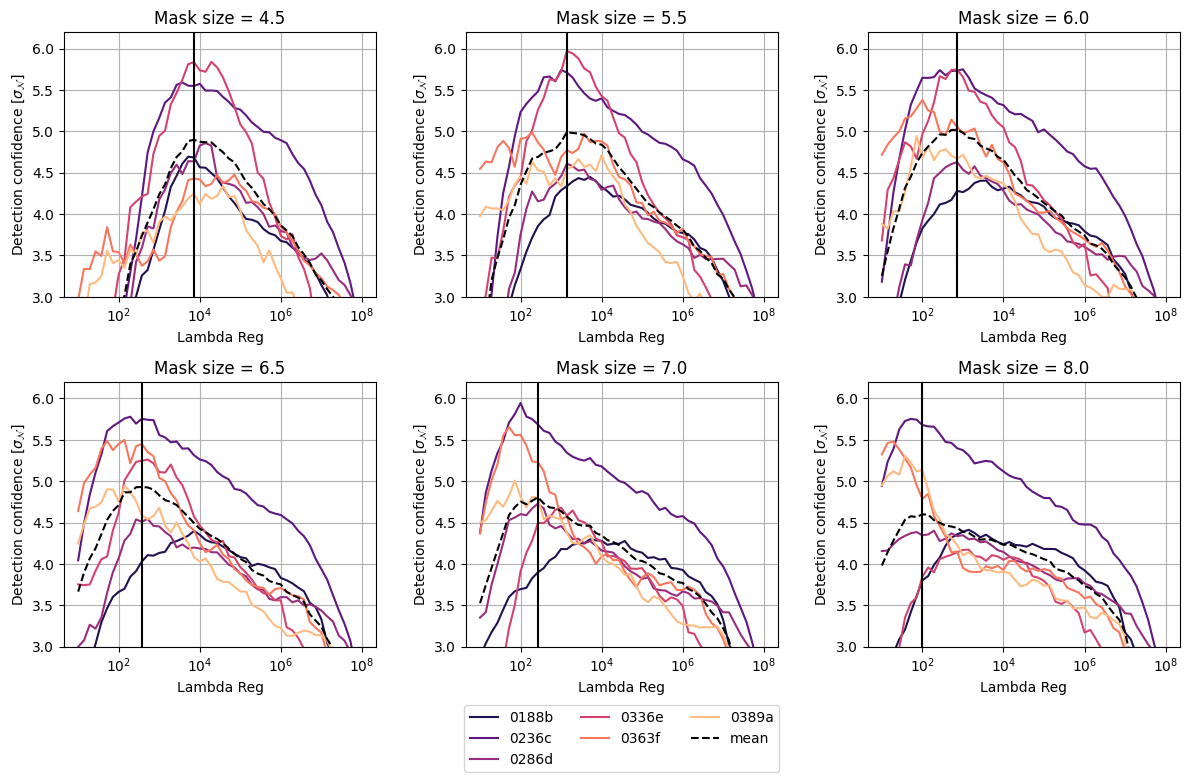

In [25]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))


for i in [(ax1, 4.5), (ax2, 5.5), (ax3, 6.0), (ax4, 6.5), (ax5, 7.0), (ax6, 8.0)]:
    tmp_ax, tmp_mask_size = i
    
    tmp_name = "{:.1f}".format(tmp_mask_size)
    
    plot_lambda_trend(tmp_mask_size, tmp_name, tmp_ax)
    
ax5.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_snr_best_lambda.pdf")

## Calculate the Median Test Error

In [30]:
from applefy.gaussianity.residual_tests import extract_circular_annulus

In [254]:
models_root_dir_error = Path("/fast/mbonse/s4/70_results/01_closed_form_hyperparameters/residuals_norm_remask_2/")

In [255]:
error_cube = xr.open_dataset(models_root_dir_error/ Path("mean_error_combined.nc"))

In [256]:
def calculate_test_error_distance(setup):
    
    test_error_img, tmp_mask, tmp_lambda, tmp_planet = setup
    
    error_values, _, _ = extract_circular_annulus(
        input_residual_frame=test_error_img,
        separation=(separation_lookup_table[tmp_planet]/2.1 - 1)/2,
        size_resolution_elements=4.2, 
        annulus_width=0.5)
    
    median_error = np.mean(error_values)
    
    return tmp_planet, tmp_mask, tmp_lambda, median_error

## compute the results dependent on the distance

In [257]:
setups = []

for tmp_planet in position_lookup_table.keys():
    for tmp_mask in error_cube.coords["mask"]:
        for tmp_lambda in lambda_regs:
            tmp_image = error_cube.sel(
                fake_planet_id="0000", 
                mask=tmp_mask,
                lamb=tmp_lambda).to_array().to_numpy()[0]

            setups.append((tmp_image, float(tmp_mask), tmp_lambda, tmp_planet))

In [258]:
%%time 
results_error_local = Parallel(n_jobs=8)(delayed(calculate_test_error_distance)(tmp_setup)
                                         for tmp_setup in setups)

CPU times: user 825 ms, sys: 611 ms, total: 1.44 s
Wall time: 10.6 s


In [259]:
local_error_results = pd.DataFrame(
    results_error_local, 
    columns=['planet', 'mask_size', 'lambda_reg', 'test_error'])

In [260]:
local_error_results.set_index(['planet', 'mask_size', 'lambda_reg'], inplace=True)
local_error_results = local_error_results.to_xarray()

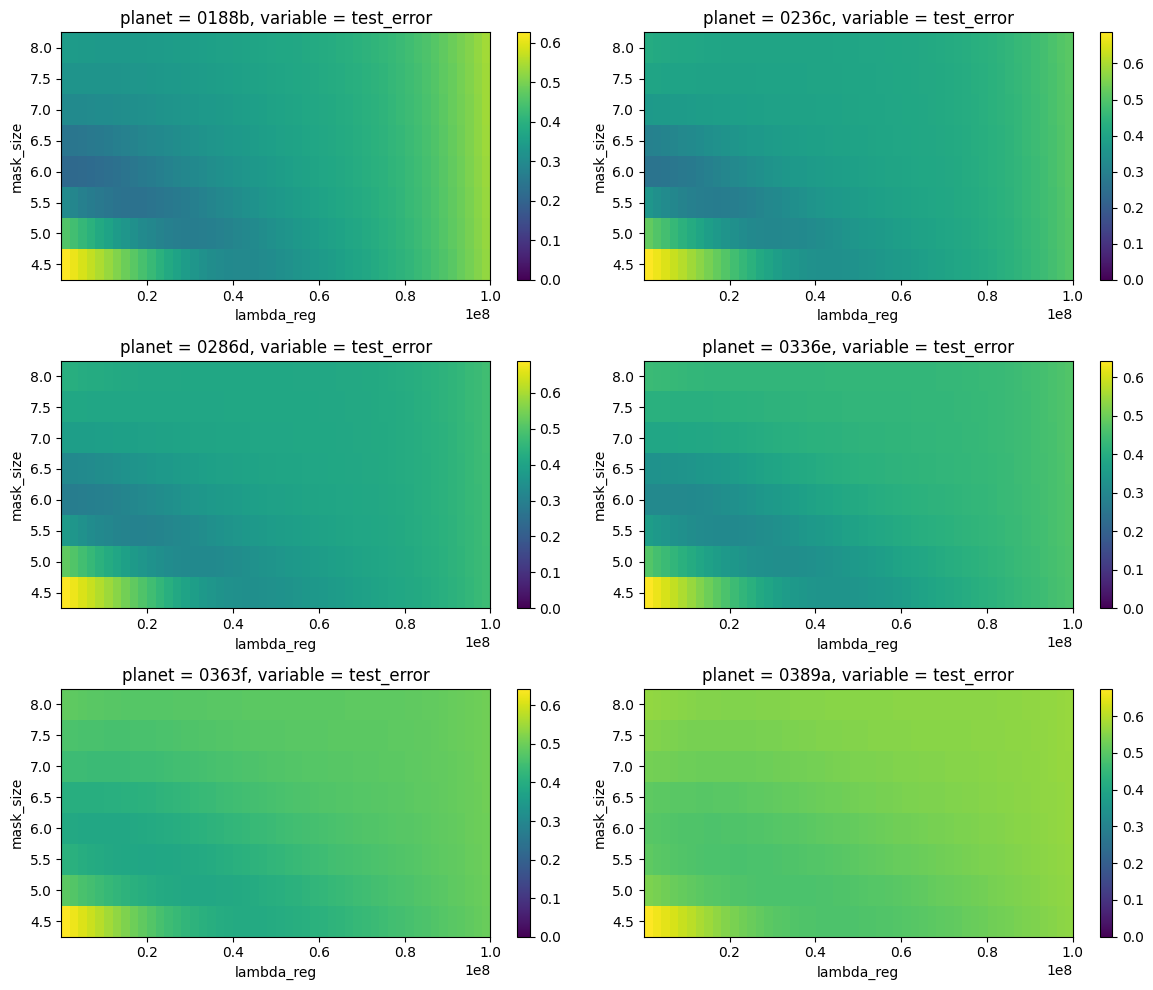

In [261]:
fig, ((ax1, ax2),(ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 10))


xr.plot.imshow(local_error_results.sel(planet="0188b").to_array()[0],
               vmin=0, ax=ax1)

xr.plot.imshow(local_error_results.sel(planet="0236c").to_array()[0], 
               vmin=0, ax=ax2)

xr.plot.imshow(local_error_results.sel(planet="0286d").to_array()[0], 
               vmin=0, ax=ax3)

xr.plot.imshow(local_error_results.sel(planet="0336e").to_array()[0], 
               vmin=0, ax=ax4)

xr.plot.imshow(local_error_results.sel(planet="0363f").to_array()[0], 
               vmin=0, ax=ax5)

xr.plot.imshow(local_error_results.sel(planet="0389a").to_array()[0], 
               vmin=0, ax=ax6)

plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_local_error_heatmaps.pdf")

In [262]:
colors = sns.color_palette("magma", 6)

# We skip a planets at 1 lambda /D. They are special...
skip = ["0071a", "0117a", "0142b", "0190c", "0240d", "0267e", "0317f","0343a"]

def plot_lambda_trend_error(
    mask_size_in,
    name_in, 
    ax_in):
    
    lambda_results = local_error_results.sel(
        mask_size=mask_size_in).to_array()[0]
    
    selected_planet_results = []
    idx = 0
    for tmp_planet_result in lambda_results:

        tmp_planet_name = str(tmp_planet_result.planet.values)

        if tmp_planet_name in skip:
            continue

        ax_in.plot(
            local_error_results.coords["lambda_reg"], 
            tmp_planet_result, 
            label=tmp_planet_name,
            color=colors[idx])
        
        selected_planet_results.append(
            tmp_planet_result.to_numpy())
        idx +=1
        
    ax_in.set_xlabel("Lambda Reg")
    ax_in.set_ylabel("Test Error")
    ax_in.set_title("Mask size = " + name_in)
    
    ax_in.set_xscale("log")
    ax_in.grid()
    
    # plot the best lambda
    selected_results = np.stack(selected_planet_results)
    #mean_results = np.mean(selected_results, axis=0)
    mean_results = lambda_results.sel(planet="0389a")
    global_min = float(local_error_results.coords["lambda_reg"][
        mean_results.argmin()])
    
    #lambda_results.sel(planet="0389a")
    
    ax_in.plot(
        local_error_results.coords["lambda_reg"], 
        mean_results,
        color="black",
        ls="--",
        label="mean")

    ax_in.vlines(global_min, 0, 0.5, color="black", lw=1.5)
    ax_in.set_ylim(lambda_results.min(), lambda_results.max())

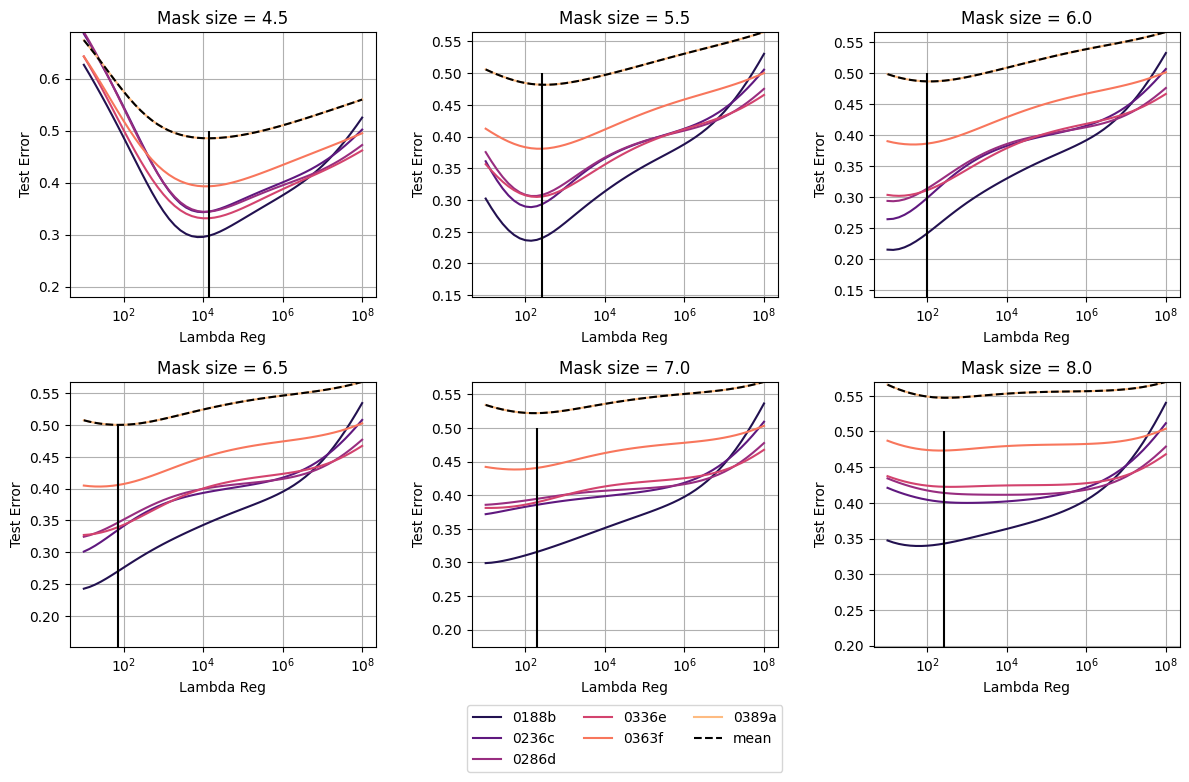

In [ ]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))


for i in [(ax1, 4.5), (ax2, 5.5), (ax3, 6.0), (ax4, 6.5), (ax5, 7.0), (ax6, 8.0)]:
    tmp_ax, tmp_mask_size = i
    
    tmp_name = "{:.1f}".format(tmp_mask_size)
    
    plot_lambda_trend_error(tmp_mask_size, tmp_name, tmp_ax)
    
ax5.legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_local_error_best_lambda.pdf")

## compute the result on the full error image

In [ ]:
def calculate_test_error_full(setup):
    
    test_error_img, tmp_mask, tmp_lambda = setup
    median_error = np.mean(test_error_img)
    
    return tmp_mask, tmp_lambda, median_error

In [265]:
setups = []
tmp_planet="0000"
for tmp_mask in error_cube.coords["mask"]:
    for tmp_lambda in lambda_regs:
        tmp_image = error_cube.sel(
            fake_planet_id=tmp_planet, 
            mask=tmp_mask,
            lamb=tmp_lambda).to_array().to_numpy()[0]

        setups.append((tmp_image, float(tmp_mask), tmp_lambda))

In [266]:
%%time 
results_error_global = Parallel(n_jobs=8)(delayed(calculate_test_error_full)(tmp_setup)
                                         for tmp_setup in setups)

CPU times: user 132 ms, sys: 49.9 ms, total: 182 ms
Wall time: 213 ms


In [267]:
global_error_results = pd.DataFrame(
    results_error_global, 
    columns=['mask_size', 'lambda_reg', 'test_error'])

In [268]:
global_error_results.set_index(['mask_size', 'lambda_reg'], inplace=True)
global_error_results = global_error_results.to_xarray()

In [271]:
mins = global_error_results.to_array()[0].T.argmin(axis=0)

In [272]:
colors = sns.color_palette("magma", 6)

# We skip a planets at 1 lambda /D. They are special...
skip = ["0071a", "0117a", "0142b", "0190c", "0240d", "0267e", "0317f","0343a"]

def plot_lambda_trend_error(
    mask_size_in,
    name_in, 
    ax_in):
    
    lambda_results = global_error_results.sel(
        mask_size=mask_size_in).to_array()[0]

    ax_in.plot(
        global_error_results.coords["lambda_reg"], 
        lambda_results,
        color="blue")
        
    ax_in.set_xlabel("Lambda Reg")
    ax_in.set_ylabel("Test Error")
    ax_in.set_title("Mask size = " + name_in)
    
    ax_in.set_xscale("log")
    ax_in.grid()
    
    # plot the best lambda
    global_min = float(global_error_results.coords["lambda_reg"][
        lambda_results.argmin()])

    ax_in.vlines(global_min, 0, 0.8, color="black", lw=1.5)
    ax_in.set_ylim(lambda_results.min(), lambda_results.max())

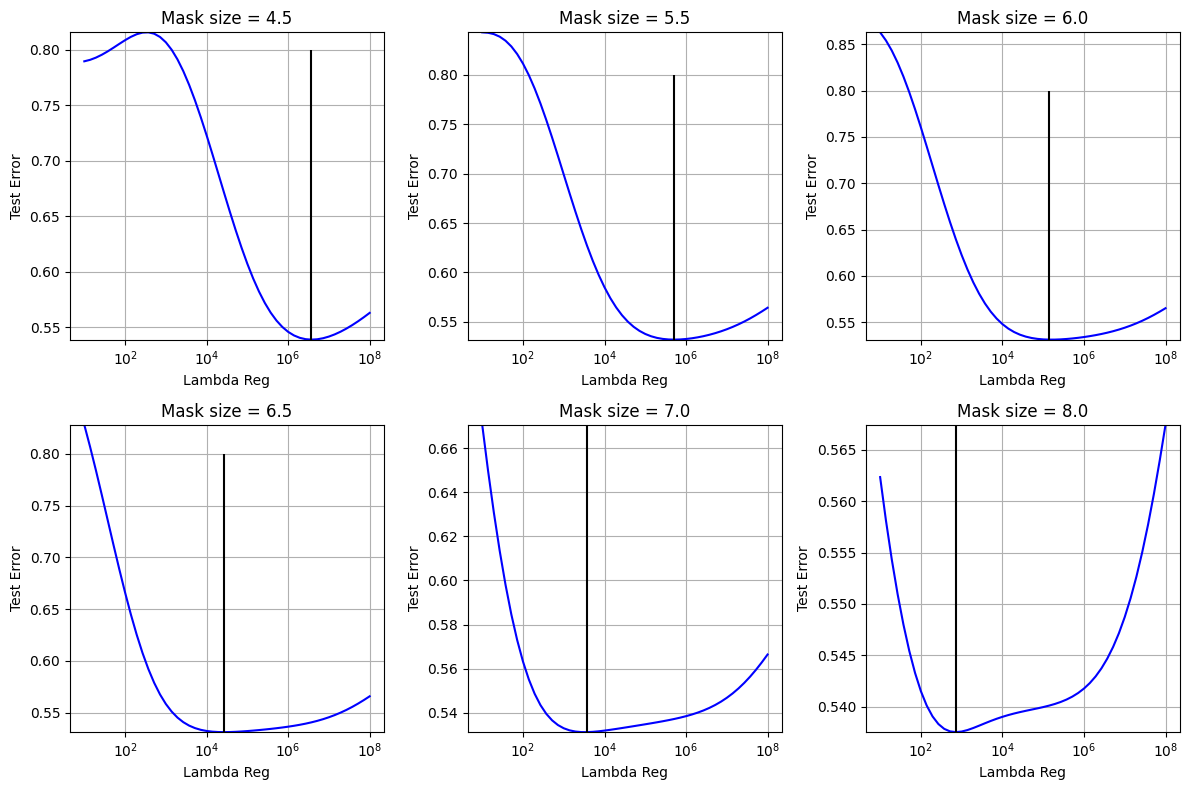

In [292]:
fig, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))


for i in [(ax1, 4.5), (ax2, 5.5), (ax3, 6.0), (ax4, 6.5), (ax5, 7.0), (ax6, 8.0)]:
    tmp_ax, tmp_mask_size = i
    
    tmp_name = "{:.1f}".format(tmp_mask_size)
    
    plot_lambda_trend_error(tmp_mask_size, tmp_name, tmp_ax)
    
plt.tight_layout()
plt.savefig("result_plots/01_lambda_mask_local_error_best_lambda.pdf")